# Compare sea surface height model output and observations

Comparing the sea-surface height (ssh) from two different resolution runs. Specifically plot the time-mean and standard deviation of ssh and compare to to observations from the AVISO dataset.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import cosima_cookbook as cc
import numpy as np

import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39003,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:35639,Total threads: 4
Dashboard: /proxy/37183/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36601,


## Start a Cosima cookbook database session

In [3]:
session = cc.database.create_session()

In [4]:
#SSH variable in ACCESS-OM2 models
variable = 'sea_level'

# dates to match the AVISO record
start_time = '1993-01-01'
end_time = '2010-12-16'

## Load SSH for a 1$^{\circ}$ run

Here we can specify the rough start and end times using the "start_time" and "end_time" arguments. But, this yields a dataset that has an extra 12 months on either end, so we slice the data to match the AVISO dataset below.

In [5]:
experiment = '1deg_jra55_iaf_omip2_cycle6'  # 1-deg experiment
ssh1 = cc.querying.getvar(experiment, variable, session, frequency='1 monthly',
                          start_time=start_time, end_time=end_time)

ssh1 = ssh1.sel(time=slice(start_time, end_time)) # slice to the same time range as AVISO
ssh1

<xarray.DataArray 'sea_level' (time: 216, yt_ocean: 300, xt_ocean: 360)>
dask.array<concatenate, shape=(216, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) datetime64[ns] 1993-01-14T12:00:00 ... 2010-12-14T12:00:00
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cy...
    contact:        Hakase Hayashida
    email:          hakase.hayashida@utas.edu.au
    created:        2021-03-03
    description:    1 degree ACCESS-OM2 global model configuration under inte...

## Load SSH for a 0.25$^{\circ}$ run

In [6]:
expt = '025deg_jra55_iaf_omip2_cycle6'  # 0.25-deg experiment
ssh025 = cc.querying.getvar(expt, variable, session, frequency='1 monthly',
                            start_time=start_time, end_time=end_time)

ssh025 = ssh025.sel(time=slice(start_time, end_time)) # slice to the same time range as AVISO
ssh025

<xarray.DataArray 'sea_level' (time: 216, yt_ocean: 1080, xt_ocean: 1440)>
dask.array<concatenate, shape=(216, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 1993-01-14T12:00:00 ... 2010-12-14T12:00:00
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_om...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

# Load AVISO observational data

Use xarray to load 'zos': the sea surface height variable name. Here we slice off the first three time points so that the data starts in January and spans an even 18 years.

In [7]:
obs = xr.open_dataset('/g/data/hh5/tmp/cosima/observations/original/zos_AVISO_L4_199210-201012.nc')   # AVISO dataset
obs_ssh = obs.zos.sel(time=slice(start_time, end_time))
obs_ssh

<xarray.DataArray 'zos' (time: 216, lat: 180, lon: 360)>
[13996800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2010-12-16T12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    standard_name:     sea_surface_height_above_geoid
    long_name:         Sea Surface Height Above Geoid
    units:             m
    original_name:     maps_of_absolute_dynamic_topography
    history:           2011-02-11, 12:02:38, AVISO, Aviso2Cmor 2009-01-01 200...
    original_units:    cm
    cell_methods:      time: mean
    cell_measures:     area: areacello
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

# Make comparison plot

Plot the time-mean and standard deviation of both of the model outputs and the AVISO data (obs).

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


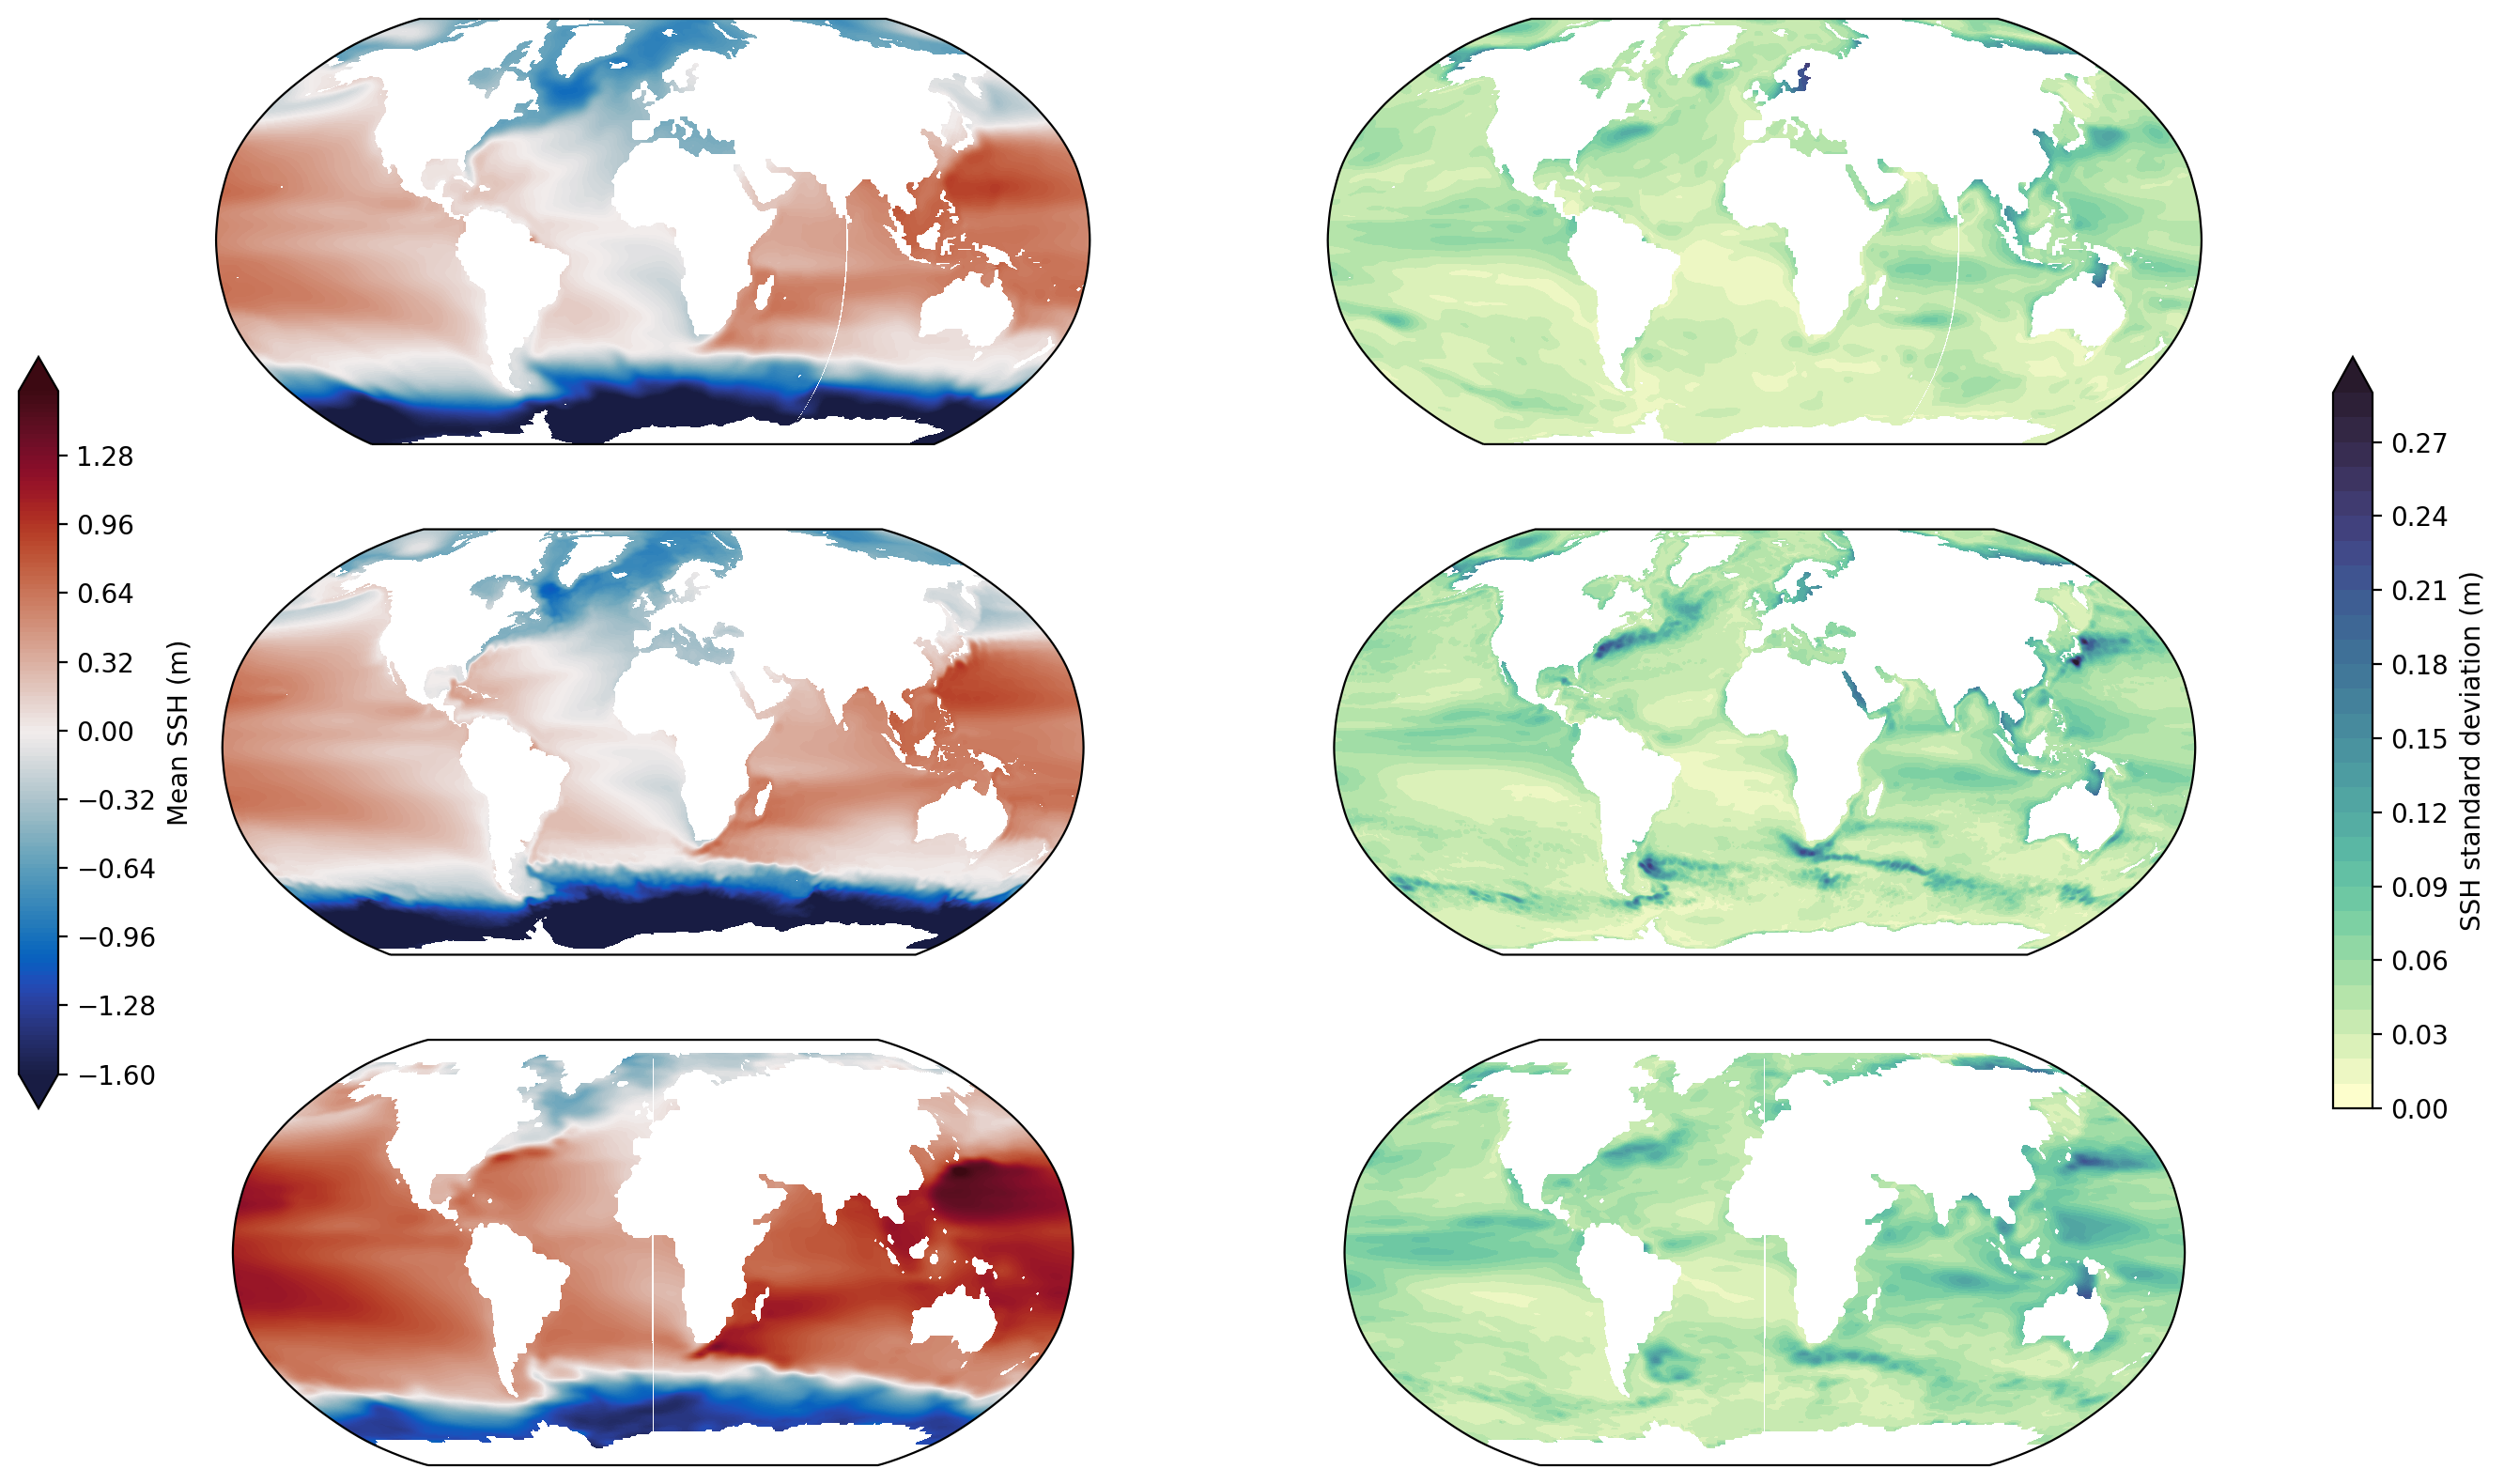

In [8]:
projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': ccrs.Robinson()})

# Define the contour levels and spacing 
mlev = np.arange(-1.6, 1.6, 0.02)  # levels for mean ssh
slev = np.arange( 0.0, 0.3, 0.01)  # levels for std ssh

# mean SSH plots
ax = axes[0, 0]
ax.set_title('mean SSH 1$^{\circ}$')
p1 = ssh1.mean(dim='time').plot.contourf(ax=ax,
                                         cmap=cm.cm.balance, levels=mlev, add_colorbar=False,
                                         extend='both', transform=ccrs.PlateCarree())

ax = axes[1, 0]
ax.set_title('mean SSH 0.25$^{\circ}$')
p1 = ssh025.mean(dim='time').plot.contourf(ax=ax,
                                           cmap=cm.cm.balance, levels=mlev, add_colorbar=False,
                                           extend='both', transform=ccrs.PlateCarree())

ax = axes[2, 0]
ax.set_title('Observations mean SSH')
p1 = obs_ssh.mean(dim='time').plot.contourf(ax=ax,
                                            cmap=cm.cm.balance, levels=mlev, add_colorbar=False,
                                            extend='both', transform=ccrs.PlateCarree())


# std SSH plots
ax = axes[0, 1]
ax.set_title('SSH standard deviation 1$^{\circ}$')
p2 = ssh1.std(dim='time').plot.contourf(ax=ax,
                                        cmap=cm.cm.deep, levels=slev, add_colorbar=False,
                                        extend='max', transform=ccrs.PlateCarree())

ax = axes[1, 1]
ax.set_title('SSH standard deviation 0.25$^{\circ}$')
p2 = ssh025.std(dim='time').plot.contourf(ax=ax,
                                          cmap=cm.cm.deep, levels=slev, add_colorbar=False,
                                          extend='max', transform=ccrs.PlateCarree())


ax = axes[2, 1]
ax.set_title('Observations SSH Standard Deviation')
p2 = obs_ssh.std(dim='time').plot.contourf(ax=ax,
                                           cmap=cm.cm.deep, levels=slev, add_colorbar=False,
                                           extend='max', transform=ccrs.PlateCarree())

# Colorbars
ax_cb1 = plt.axes([0.06, 0.3, 0.015, 0.4])
cb = plt.colorbar(p1, cax=ax_cb1, label='Mean SSH (m)')

ax_cb2 = plt.axes([0.94, 0.3, 0.015, 0.4])
cb = plt.colorbar(p2, cax=ax_cb2, label='SSH standard deviation (m)');